In [2]:
import pandas as pd
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
news = pd.read_csv('../Data/corona_news_scraped_on_23rd_march.csv')
news.head()

,datetime,text
0,"23:37 (IST), Mar 22",Republican Rand Paul becomes first US senator ...
1,"23:34 (IST), Mar 22","Coronavirus: SC cancels benches, only one cour..."
2,"23:30 (IST), Mar 22",German Chancellor Angela Merkel will quarantin...
3,"22:59 (IST), Mar 22",There was a case reported of suspected Covid-1...
4,"22:48 (IST), Mar 22","Italy reports 651 new virus death, toll nears ..."


In [4]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
datetime    330 non-null object
text        330 non-null object
dtypes: object(2)
memory usage: 5.2+ KB


In [5]:
nlp = spacy.load('en_core_web_sm')

### Cleaning up for NLP tasks

In [6]:
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
    text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']    
        

In [7]:
news['cleaned_text'] = news.text.apply(remove_html)
news['cleaned_text'] = news.cleaned_text.apply(stop_words_remover)
news['cleaned_text'] = news.cleaned_text.apply(lemmatize_words)
news['cleaned_text'] = news.cleaned_text.apply(punctuation_remover)
news['cleaned_text'] = news.cleaned_text.apply(word_tokenize)

In [8]:
news.head()

,datetime,text,cleaned_text
0,"23:37 (IST), Mar 22",Republican Rand Paul becomes first US senator ...,"[republican, rand, paul, become, first, senato..."
1,"23:34 (IST), Mar 22","Coronavirus: SC cancels benches, only one cour...","[coronavirus, sc, cancel, bench, one, court, h..."
2,"23:30 (IST), Mar 22",German Chancellor Angela Merkel will quarantin...,"[german, chancellor, angela, merkel, quarantin..."
3,"22:59 (IST), Mar 22",There was a case reported of suspected Covid-1...,"[case, report, suspect, covid-19, passenger, a..."
4,"22:48 (IST), Mar 22","Italy reports 651 new virus death, toll nears ...","[italy, report, 651, new, virus, death, toll, ..."


### Topic Modelling

#### Unigram

In [9]:
# Create Corpora
dictionary = corpora.Dictionary(news.cleaned_text)

# Create document term Matrix (Bag of words)
document_bow = [dictionary.doc2bow(doc) for doc in news.cleaned_text ]

In [10]:
lda_model = LdaModel(corpus=document_bow ,num_topics=10, id2word=dictionary,passes = 100)

In [11]:
for i, topic in lda_model.print_topics(-1):
    print('Topic: {} Words :{}'.format(i,topic))

Topic: 0 Words :0.034*"case" + 0.023*"positive" + 0.017*"total" + 0.015*"number" + 0.015*"report" + 0.014*"rise" + 0.013*"india" + 0.012*"coronavirus" + 0.012*"covid-19" + 0.010*"test"
Topic: 1 Words :0.016*"coronavirus" + 0.013*"district" + 0.013*"impose" + 0.013*"144" + 0.013*"section" + 0.011*"positive" + 0.011*"public" + 0.011*"kerala" + 0.009*"'s" + 0.009*"health"
Topic: 2 Words :0.020*"ban" + 0.011*"gathering" + 0.010*"delhi" + 0.009*"mumbai" + 0.009*"germany" + 0.008*"two" + 0.008*"market" + 0.008*"remain" + 0.008*"spread" + 0.007*"today"
Topic: 3 Words :0.025*"covid-19" + 0.018*"case" + 0.014*"testing" + 0.013*"private" + 0.013*"ministry" + 0.013*"say" + 0.011*"test" + 0.011*"health" + 0.011*"government" + 0.010*"issue"
Topic: 4 Words :0.028*"ani" + 0.023*"#" + 0.022*"https" + 0.022*"@" + 0.022*":" + 0.019*"bell" + 0.019*"express" + 0.019*"…" + 0.018*"gratitude" + 0.016*"ring"
Topic: 5 Words :0.041*"march" + 0.038*"lockdown" + 0.034*"till" + 0.028*"state" + 0.025*"service" + 0.

In [12]:
lda_display = pyLDAvis.gensim.prepare(lda_model,document_bow,dictionary,sort_topics=False)
pyLDAvis.display(lda_display)

### Sentiment Analysis

In [13]:
def test_sentiment_analyzer(use_textblob = True ,use_vader=False):
    for sentence in news.text[50:60]:
        print(sentence,'\n')
        analyzed_sentence = TextBlob(sentence) if use_textblob==True  \
                             else SentimentIntensityAnalyzer().polarity_scores(sentence)
        print(analyzed_sentence.sentiment if use_textblob==True else analyzed_sentence,'\n')

In [14]:
test_sentiment_analyzer(use_textblob=True)

Read: Switzerland records more than 900 more coronavirus cases 

Sentiment(polarity=0.5, subjectivity=0.5) 

All types of commercial vehicles, including buses & tempos, will remain off the roads in Assam till Tuesday: State apex transport association 

Sentiment(polarity=0.0, subjectivity=0.0) 

Emirates to suspend all passenger flights from March 25 

Sentiment(polarity=0.0, subjectivity=0.0) 

Death toll due to Covid-19 rises to 7 in India; total number of cases climb to 360: Union health ministry 

Sentiment(polarity=-0.0625, subjectivity=0.5625) 

Mumbai CSTM wears a deserted look 

Sentiment(polarity=0.0, subjectivity=0.0) 

Woman, son test positive for coronavirus in Greater Noida (West), total number of cases in Gautam Buddh Nagar 8: Officials 

Sentiment(polarity=0.24242424242424243, subjectivity=0.5984848484848485) 

J&K orders shutdown of all establishments and services except essential commodities till March 31 

Sentiment(polarity=0.0, subjectivity=0.3) 

US Treasury secret

In [15]:
test_sentiment_analyzer(use_textblob=False,use_vader=True)

Read: Switzerland records more than 900 more coronavirus cases 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

All types of commercial vehicles, including buses & tempos, will remain off the roads in Assam till Tuesday: State apex transport association 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

Emirates to suspend all passenger flights from March 25 

{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'compound': -0.3182} 

Death toll due to Covid-19 rises to 7 in India; total number of cases climb to 360: Union health ministry 

{'neg': 0.176, 'neu': 0.766, 'pos': 0.059, 'compound': -0.5574} 

Mumbai CSTM wears a deserted look 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

Woman, son test positive for coronavirus in Greater Noida (West), total number of cases in Gautam Buddh Nagar 8: Officials 

{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.7506} 

J&K orders shutdown of all establishments and services except essential commodities till March 31 

{'n

#### _We will use vader sentiment analyzer as results are somewhat better_

In [16]:
def sentiment_calculator(text):
    analyzer =  SentimentIntensityAnalyzer().polarity_scores(text)
    return analyzer['compound']

news['sentiment_score'] = news.text.apply(sentiment_calculator)

In [17]:
label = ( lambda x : 'positive' if x > 0.05 else 'negative' )

news['sentiment'] = news.sentiment_score.apply(label)

In [18]:
news.head()

,datetime,text,cleaned_text,sentiment_score,sentiment
0,"23:37 (IST), Mar 22",Republican Rand Paul becomes first US senator ...,"[republican, rand, paul, become, first, senato...",0.5574,positive
1,"23:34 (IST), Mar 22","Coronavirus: SC cancels benches, only one cour...","[coronavirus, sc, cancel, bench, one, court, h...",-0.0258,negative
2,"23:30 (IST), Mar 22",German Chancellor Angela Merkel will quarantin...,"[german, chancellor, angela, merkel, quarantin...",0.7096,positive
3,"22:59 (IST), Mar 22",There was a case reported of suspected Covid-1...,"[case, report, suspect, covid-19, passenger, a...",-0.6705,negative
4,"22:48 (IST), Mar 22","Italy reports 651 new virus death, toll nears ...","[italy, report, 651, new, virus, death, toll, ...",-0.5994,negative


In [19]:
news.iloc[0].text

'Republican Rand Paul becomes first US senator to test positive for coronavirus'

### TF-IDF

In [20]:
tfidf = TfidfModel(document_bow)
corpus_tfidf = tfidf[document_bow]

In [21]:
d ={}
for doc in corpus_tfidf:
    for id, value in doc:
        word = dictionary.get(id)
        d[word] = value

In [22]:
tfidf_word_with_score = pd.DataFrame.from_dict( d ,orient = 'index',columns = ['score'])
tfidf_word_with_score.sort_values(by = 'score',ascending =False,inplace=True)
tfidf_word_with_score.head(20)

,score
tracking,0.907034
ghat,0.750537
peak,0.725738
mother,0.709966
tracker,0.700200
picture,0.700200
trader,0.656547
pence,0.638592
goa,0.630493
switzerland,0.612444


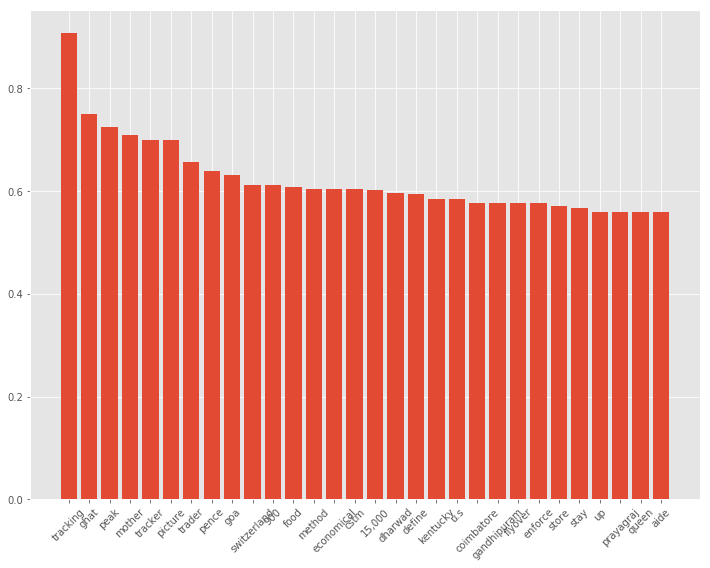

In [23]:
plt.style.use('ggplot')
plt.figure(figsize=(12,9))
plt.xticks(rotation='45')
plt.bar(tfidf_word_with_score.index[:30],tfidf_word_with_score.score[:30])
plt.show()

In [24]:
lda_model_tfidf = LdaModel(corpus=corpus_tfidf ,num_topics=10,id2word=dictionary,passes =150)

In [25]:
for i, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Words :{}'.format(i,topic))

Topic: 0 Words :0.008*"curfew" + 0.007*"janta" + 0.006*"march" + 0.006*"passenger" + 0.006*"till" + 0.006*"train" + 0.006*"observe" + 0.005*"ani" + 0.005*"people" + 0.005*"railway"
Topic: 1 Words :0.004*"switzerland" + 0.004*"900" + 0.004*"test" + 0.004*"attend" + 0.003*"mizoram" + 0.003*"record" + 0.003*"facility" + 0.003*"bihar" + 0.003*"district" + 0.003*"store"
Topic: 2 Words :0.009*"death" + 0.008*"flight" + 0.008*"airport" + 0.007*"india" + 0.006*"toll" + 0.006*"rise" + 0.006*"total" + 0.005*"indian" + 0.005*"number" + 0.005*"domestic"
Topic: 3 Words :0.004*"chief" + 0.004*"monday" + 0.004*"curfew" + 0.004*"nationwide" + 0.004*"minister" + 0.004*"janta" + 0.004*"greece" + 0.003*"state" + 0.003*"first" + 0.003*"paul"
Topic: 4 Words :0.006*"144" + 0.006*"section" + 0.005*"crpc" + 0.005*"impose" + 0.004*"screening" + 0.004*"kerala" + 0.004*"district" + 0.004*"order" + 0.004*"restrict" + 0.004*"kozhikode"
Topic: 5 Words :0.008*"case" + 0.008*"positive" + 0.006*"hospital" + 0.006*"tes

In [26]:
for index, score in sorted(lda_model_tfidf[document_bow[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6122970581054688	 
Topic: 0.008*"curfew" + 0.007*"janta" + 0.006*"march" + 0.006*"passenger" + 0.006*"till" + 0.006*"train" + 0.006*"observe" + 0.005*"ani" + 0.005*"people" + 0.005*"railway"

Score: 0.3476793169975281	 
Topic: 0.012*"march" + 0.011*"service" + 0.011*"till" + 0.009*"31" + 0.009*"essential" + 0.008*"lockdown" + 0.007*"midnight" + 0.005*"jharkhand" + 0.004*"22" + 0.004*"govt"


In [27]:
topics_list = []
for index in news.index:
    topic_dic = {}
    
    for i, score in sorted(lda_model_tfidf[document_bow[index]], key=lambda tup: -1*tup[1]):
        topic_dic['i'] = i
        topic_dic['score'] = score
        continue
    
    topics_list.append(topic_dic.get('i'))

In [28]:
news['topic'] = topics_list

In [29]:
news.head()

,datetime,text,cleaned_text,sentiment_score,sentiment,topic
0,"23:37 (IST), Mar 22",Republican Rand Paul becomes first US senator ...,"[republican, rand, paul, become, first, senato...",0.5574,positive,8
1,"23:34 (IST), Mar 22","Coronavirus: SC cancels benches, only one cour...","[coronavirus, sc, cancel, bench, one, court, h...",-0.0258,negative,8
2,"23:30 (IST), Mar 22",German Chancellor Angela Merkel will quarantin...,"[german, chancellor, angela, merkel, quarantin...",0.7096,positive,9
3,"22:59 (IST), Mar 22",There was a case reported of suspected Covid-1...,"[case, report, suspect, covid-19, passenger, a...",-0.6705,negative,5
4,"22:48 (IST), Mar 22","Italy reports 651 new virus death, toll nears ...","[italy, report, 651, new, virus, death, toll, ...",-0.5994,negative,2


In [30]:
news.sentiment.value_counts()

negative    212
positive    118
Name: sentiment, dtype: int64

In [31]:
news.topic.value_counts()

0    54
5    53
9    45
6    44
2    41
8    31
4    21
3    15
1    14
7    12
Name: topic, dtype: int64

In [32]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf,document_bow,dictionary,sort_topics=False)
pyLDAvis.display(lda_display)

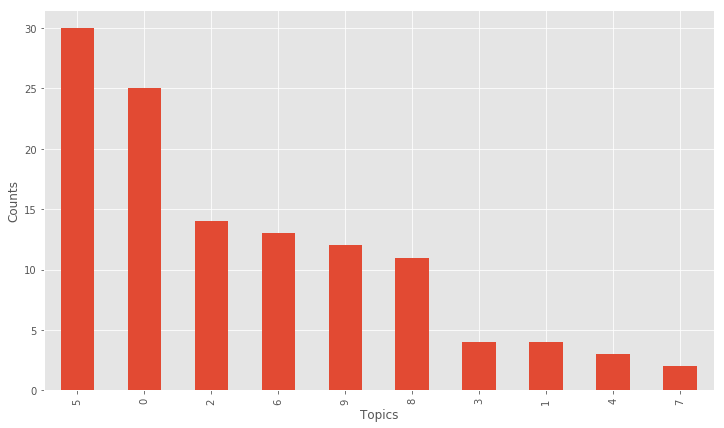

In [33]:
# Check count of topics by sentiment
plt.figure(figsize=(12,7))
plt.xlabel('Topics')
news[news.sentiment == 'positive']['topic'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

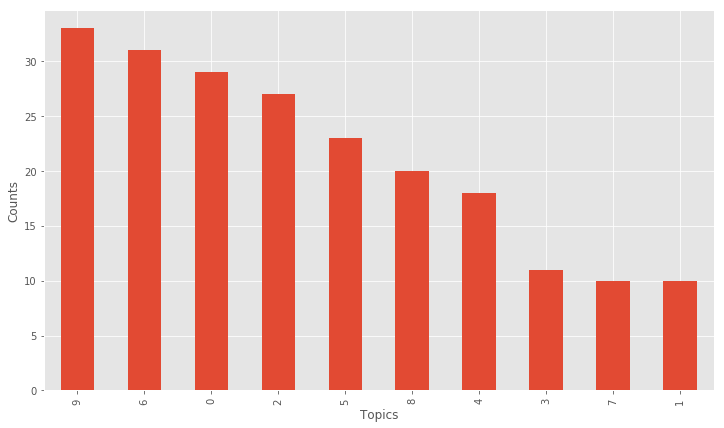

In [34]:
plt.figure(figsize=(12,7))
plt.xlabel('Topics')
news[news.sentiment == 'negative']['topic'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

In [35]:
#POS Tagging
# -- POS Tagging-- See PROPN, 
# -- Verbs wont make useful info, 
# -- Form questions that need to be answered .
# NER -- Find places 

# ---  Cleaned up logic of topics --- > PROPN for each topic , ENTITIES GPE or 


# New entities 

In [36]:
lda_model_tfidf = LdaModel(corpus=corpus_tfidf ,num_topics=6,id2word=dictionary,passes =150)
for i, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Words :{}'.format(i,topic))

Topic: 0 Words :0.004*"germany" + 0.004*"ban" + 0.003*"spread" + 0.003*"gathering" + 0.003*"two" + 0.003*"virus" + 0.003*"public" + 0.003*"declare" + 0.003*"test" + 0.002*"pence"
Topic: 1 Words :0.004*"peak" + 0.003*"happen" + 0.003*"aiim" + 0.003*"test" + 0.003*"woman" + 0.003*"positive" + 0.003*"admit" + 0.003*"clap" + 0.003*"noida" + 0.002*"ring"
Topic: 2 Words :0.006*"curfew" + 0.005*"janta" + 0.005*"airport" + 0.004*"observe" + 0.004*"march" + 0.004*"people" + 0.004*"railway" + 0.003*"train" + 0.003*"remain" + 0.003*"till"
Topic: 3 Words :0.007*"case" + 0.007*"total" + 0.006*"rise" + 0.005*"death" + 0.005*"india" + 0.005*"positive" + 0.004*"report" + 0.004*"number" + 0.004*"covid-19" + 0.004*"coronavirus"
Topic: 4 Words :0.005*"march" + 0.005*"till" + 0.004*"service" + 0.004*"31st" + 0.004*"state" + 0.004*"district" + 0.004*"lockdown" + 0.003*"75" + 0.003*"delhi" + 0.003*"say"
Topic: 5 Words :0.004*"march" + 0.004*"service" + 0.004*"state" + 0.004*"impose" + 0.004*"till" + 0.004*"

In [37]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf,document_bow,dictionary,sort_topics=False)
pyLDAvis.display(lda_display)